In [70]:
import rasterio
import geopandas as gpd
import pyproj
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import lightgbm as lgbm
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from numpy import *
import numpy as np
from sklearn.model_selection import train_test_split

In [71]:
def concat(AOI_path, outdir, singledate):
    
    #list of Training data samples
    if singledate is False:
        lit = glob.glob(AOI_path + '*//Sampled//SD.shp')
    else:
        lit = glob.glob(AOI_path + '20200306//Sampled//SD.shp')
        lit.append('C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Dates/20200314//Sampled//SD.shp')
    print('Training Data', lit)
    i = 0
    for item in lit:
        pts = gpd.read_file(item)
        if i != 0:
            df_train = pd.concat([df_train,pts])
        else: 
            df_train = pts
            i=i+1   
    df_train.to_file(outdir + 'SD_concat.shp')        
    return df_train

AOI_path = 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Dates/'
outdir = 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Training_Data/'

Training_Data = concat(AOI_path, outdir, True)

Training Data ['C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Dates/20200306//Sampled//SD.shp', 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Dates/20200314//Sampled//SD.shp']


In [72]:
def stack(path):
    VH = os.path.join(path , "VH.tif")
    Diff = os.path.join(path , "Diff.tif")
    Ratio = os.path.join(path , "Ratio.tif")
    Subtract = os.path.join(path , "Subtract.tif")
    #DEM =  'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/DEM/mergedDEM100m.tif'
    DEM = 'C://Users/Rasmu/Documents/Thesis/Hardangervidda/DEM/mergedDEM100m.tif'
    listofmasks=[VH, Diff, Ratio, Subtract, DEM]
    print(listofmasks)
    
    lit_ravel = []
    i=0
    for rst in listofmasks:
        with rasterio.open(rst) as src:
            srcdata = src.read()
            print(srcdata.shape,'shape')
            ravel = srcdata[0].ravel()
            lit_ravel.append(ravel)
            profile = src.profile
            og_shape = srcdata.shape
            i=i+1
    
    print(len(lit_ravel))
    return lit_ravel, profile, og_shape

In [73]:
def model(Training_Data_Path, Prediction_Path, outdir): 
    
    pts = gpd.read_file(Training_Data_Path)
    pts = pts[pts['SD'] < 6]
    X = pts.drop(columns=['SD', 'geometry'])
    y = pts['SD']
    
    X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.33, random_state=42)
    #X = X.replace(np.nan, 0)     
    reg = lgbm.LGBMRegressor()
    #reg.fit(X_train, y_train)
    reg.fit(X, y)
    #reg = RandomForestRegressor(max_depth=2, random_state=0).fit(X,y)
    importances = reg.feature_importances_
    print('importance', importances)
    
    lit_ravel, profile, og_shape = stack(Prediction_Path)
    
    X_test = np.transpose(lit_ravel)
    #X_test[np.isnan(X_test)] = 0 
    print(X.shape)
    print(X_test.shape)
    y_pred = reg.predict(X_test)  # make predictions
    print('modelling done')    

    #Predict on training to calc R2
    
    y_pred_val = reg.predict(X_val)
    y_pred_train = reg.predict(X)
    #Calculate R2    
    r2 = r2_score(y, y_pred_train).round(2)
    r2 = format(r2, '.2f')
    print('r2_train', r2)
    
    r2 = r2_score(y_val, y_pred_val).round(2)
    r2 = format(r2, '.2f')    
    print('r2_val', r2)
    
    Binary_Mask = Prediction_Path[:-3] + 'Masks/Binary_Mask.tif'
    with rasterio.open(Binary_Mask) as mask:
            srcdata = mask.read()
            B_Mask = srcdata[0].ravel()
    y_pred = y_pred * B_Mask  
    y_pred[y_pred==0] = np.nan
    y_pred = y_pred.reshape(og_shape)
    
    with rasterio.open(outdir + 'Prediction_20200306_test3.tif', 'w', **profile) as dst:
        dst.write(y_pred.astype(rasterio.float32))
        
    return y_pred_val,y_val, y_pred_train, y


Training_Data_Path = 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Training_Data/'
Prediction_Path = 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Dates/20200306/S1/'
outdir = 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Results/'
y_pred_val,y_val,y_pred_train, y = model(Training_Data_Path, Prediction_Path, outdir)

importance [540 673 525 605 657]
['C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Dates/20200306/S1/VH.tif', 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Dates/20200306/S1/Diff.tif', 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Dates/20200306/S1/Ratio.tif', 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Dates/20200306/S1/Subtract.tif', 'C://Users/Rasmu/Documents/Thesis/Hardangervidda/DEM/mergedDEM100m.tif']
(1, 1206, 1550) shape
(1, 1206, 1550) shape
(1, 1206, 1550) shape
(1, 1206, 1550) shape
(1, 1206, 1550) shape
5
(1634, 5)
(1869300, 5)
modelling done
r2_train 0.88
r2_val 0.88


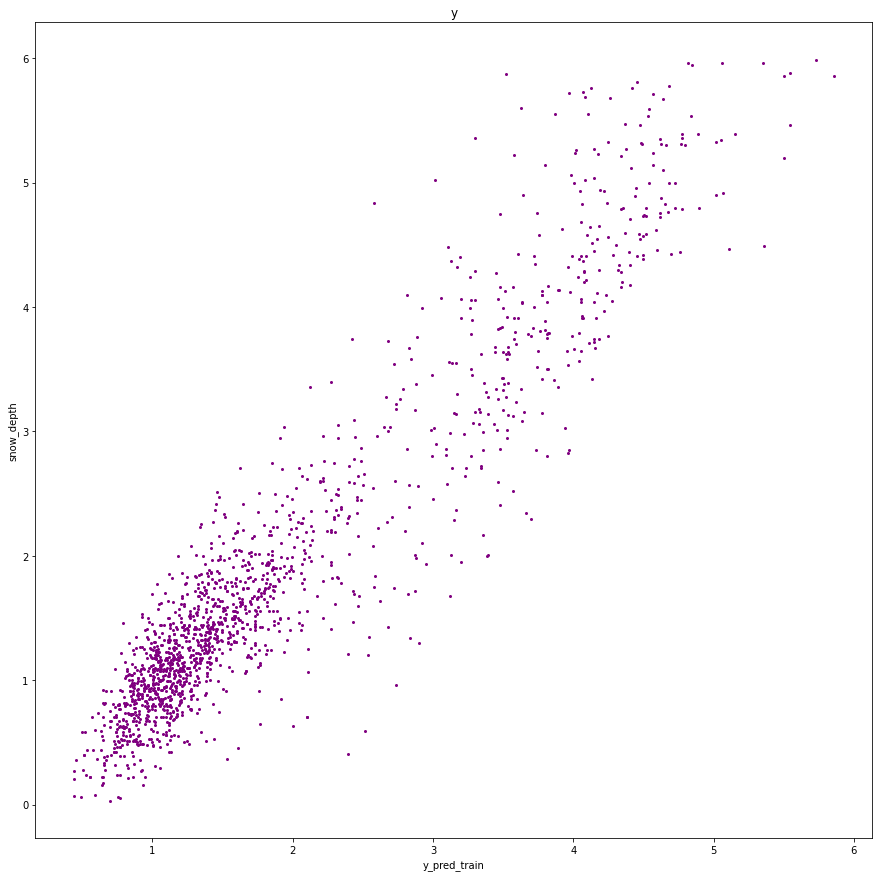

In [74]:
plt.figure(figsize=(15, 15))
plt.title('y')
plt.xlabel('y_pred_train')
plt.ylabel('snow_depth')
#plt.scatter(y_pred_val, y_val, color='purple', s=4);
plt.scatter(y_pred_train, y, color='purple', s=4);
#plt.xlim([800, 1600])